# Attention Values

In [ ]:
%cd ..

In [2]:
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.utils.config import pipeline_config

%matplotlib inline

In [3]:
audio_path = "data/raw/canonical_data/pediatric_studies/Pn_{}_{}/{}/audio/{}_{}.wav"
label_path = "data/raw/canonical_data/pediatric_studies/Pn_{}_{}/{}/labels/{}_{}.txt"
as_audio_path = "data/raw/canonical_data/pediatric_studies/As_{}_{}/{}/audio/{}_{}_S1_a.wav"
as_label_path = "data/raw/canonical_data/pediatric_studies/As_{}_{}/{}/labels/{}_{}_S1_a.txt"

In [4]:
patient_df = pd.read_csv("data/processed/patient_df.csv")
train_loc = pipeline_config["train_loc"]

In [5]:
patient_df

,patient,location,fold,diagnosis,old_diagnosis,all_diagnoses,multilabel
0,Pn_GVA_Co1,GVA,4,0,0,[0],False
1,Pn_GVA_Co2,GVA,0,0,0,[0],False
2,Pn_GVA_Co3,GVA,1,0,0,[0],False
3,Pn_GVA_Co4,GVA,2,0,0,[0],False
4,Pn_GVA_Co5,GVA,3,0,0,[0],False
...,...,...,...,...,...,...,...
588,Pn_RBA_Ca27,RBA,4,4,-1,[4],False
589,Pn_RBA_Ca28,RBA,0,4,-1,[4],False
590,Pn_RBA_Ca33,RBA,1,4,-1,[4],False
591,Pn_RBA_Ca34,RBA,2,4,-1,[4],False


In [6]:
from math import ceil

def get_start_idx(time, rate=4000, n_fft=256, hop_length=64):
    start_time = -(n_fft / 2) / rate
    idx = ceil((time - start_time) * (rate / hop_length))
    return idx


def get_end_idx(time, rate=4000, n_fft=256, hop_length=64):
    start_time = -(n_fft / 2) / rate
    idx = int((rate / hop_length) * (time - (n_fft / rate) - start_time))
    return idx

In [7]:
def mean_attention_values(labels_df, frame_attention, all_labels):
    attention_values = {l: [] for l in all_labels}
    step = 0
    end_idx = labels_df.at[step, "end_idx"]
    
    for idx, fa in enumerate(frame_attention):
        while (step < len(labels_df)-1) and (idx > end_idx):
            step += 1
            end_idx = labels_df.at[step, "end_idx"]

        start_idx = labels_df.at[step, "start_idx"]
        labels = labels_df.at[step, "label"]

        if start_idx <= idx <= end_idx:
            for label in labels:
                attention_values[label].append(fa)
                
    mean_attention = {label: np.mean(attn_vals if attn_vals else [0]) for label, attn_vals in attention_values.items()}
    
    return mean_attention

In [8]:
def get_test_data(val_fold, test_fold, target):
    position_df = patient_df.copy()
    target_str = '+'.join([str(t) for t in target])
    labels = (position_df.diagnosis.isin(target)).values.astype(int)
    position_df["label"] = labels

    loc_selection = (position_df.location.isin(train_loc)).values
    val_indices = (position_df.fold == val_fold).values & loc_selection
    test_indices = (position_df.fold == test_fold).values | (~loc_selection)

    position_df = position_df.assign(set="train")
    position_df.loc[val_indices, "set"] = "val"
    position_df.loc[test_indices, "set"] = "test"

    # Get model outputs
    agg_dir = join("out", "aggregate")
    output_df_file = join(agg_dir,
                          pipeline_config["aggregate_file"].format(pipeline_config["network"]["feature_model"], target_str, val_fold, test_fold))
    output_df = pd.read_csv(output_df_file)
    position_df = position_df.merge(output_df, on="patient")
    
    # Get attention values
    feat_dir = join("out", "features")
    attn_file = join(feat_dir,
                     pipeline_config["attn_file"].format(pipeline_config["network"]["feature_model"], target_str, val_fold, test_fold))
    attn_vals = np.load(attn_file)
    
    # Keep only test data
    test_filter = (position_df.set == "test").values
    position_df = position_df[test_filter].reset_index(drop=True)
    print(len(attn_vals), len(test_filter))
    attn_vals = attn_vals[test_filter]
    
    return position_df, attn_vals

In [9]:
from os.path import isfile, join
from sklearn.preprocessing import minmax_scale


def frame_statistics(val_fold, test_fold, target):

    position_df, attn_vals = get_test_data(val_fold, test_fold, target)

    selection = (position_df.location == "GVA").values
    selected_df = position_df[selection].reset_index(drop=True)
    attn_vals = attn_vals[selection]
    
    out_df = []
    
    for idx, r in selected_df.iterrows():
        patient_id = r["patient"] 
        location = r["location"] 
        diagnosis = r["diagnosis"]
        position = r["position"]
        study = patient_id.split('_')[0]
        #correct_count = statistics_df.at[patient_id, "correct_count"]
        
        folder = "Cases" if diagnosis else "Controls"
        if study == "Pn":
            audio_file = audio_path.format(location, folder, patient_id, patient_id, position)
            label_file = label_path.format(location, folder, patient_id, patient_id, position)
        else:
            audio_file = as_audio_path.format(location, folder, patient_id, patient_id, position)
            label_file = as_label_path.format(location, folder, patient_id, patient_id, position)
        
        frame_attention = attn_vals[idx]
        n_frames = int(frame_attention[-1])
        frame_attention = frame_attention[:n_frames]
            
        if isfile(label_file):
            labels_df = pd.read_csv(label_file, sep='\t', header=None, names=["start", "end", "label"], dtype=str)
            labels_df["start"] = labels_df.start.apply(lambda s: float(s.replace(',', '.')))
            labels_df["end"] = labels_df.end.apply(lambda s: float(s.replace(',', '.')))
            labels_df["label"] = labels_df.label.fillna('NaN').apply(lambda s: s.split())
            labels_df["start_idx"] = labels_df.start.apply(lambda s: get_start_idx(s))
            labels_df["end_idx"] = labels_df.end.apply(lambda s: get_end_idx(s))
            all_labels = sorted(labels_df.explode("label").label.unique())
            mean_attention = mean_attention_values(labels_df, frame_attention, all_labels)
            
            new_r = {
                "patient": patient_id,
                "location": location,
                "diagnosis": diagnosis,
                #"correct_count": correct_count,
                "position": position,
                "val_fold": val_fold,
                "test_fold": test_fold,
                "idx": idx
            }
            
            for label, mean_attn in mean_attention.items():
                new_r[f"{label}_mean_attn"] = mean_attn
            
            out_df.append(new_r)
    
    out_df = pd.DataFrame(out_df).set_index(['patient', 'location', 'position', 'val_fold', 'test_fold', 'idx'])  # correct_count
    
    return out_df

In [10]:
def get_frame_stats(target):
    out_ls = []
    target_str = '+'.join([str(t) for t in target])

    for fold_1, fold_2 in pipeline_config["cv_folds"]:
        print('#'*25, f"FOLD {fold_1}-{fold_2}", '#'*25)
        out_ls.append(frame_statistics(fold_1, fold_2, target))
        print()
        print('#'*25, f"FOLD {fold_2}-{fold_1}", '#'*25)
        out_ls.append(frame_statistics(fold_2, fold_1, target))
        print()

    out_df = pd.concat(out_ls, sort=True)
    
    first_column = out_df.pop('diagnosis')
    out_df.insert(0, 'diagnosis', first_column)
    out_df.to_csv(f"notebooks/out/attn_stats_{target_str}.csv")
    
    return out_df

In [11]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [12]:
sns.set_style("whitegrid")

In [13]:
classes = ["Control", "Bact. Pneumonia", "Viral Pneumonia", "Obst. Bronchitis", "Asthma", "Bronchiolitis"]

In [14]:
fontsize = 15  # 18
titlesize = 17  # 24
plt.rc('font', size=fontsize) 
#plt.rc('font', size=fontsize, weight="bold")          # controls default text sizes
plt.rc('axes', titlesize=titlesize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=titlesize)  # fontsize of the figure title

In [15]:
targets = [[0], [1,2], [3,4], [5]]
names = ["Control", "Pneumonia", "Wheezing Disorder", "Bronchiolitis"]

In [16]:
def plot_attn_histograms(attn_df, target_str, min_x=-0.85, max_x=0.85, max_y=0.5, y_text=0.44):
    fig, ax = plt.subplots(nrows=len(targets), ncols=1, sharex=True, sharey=True, figsize=(12,15))

    fig_file = f"report/figures/mad_histograms_{target_str}.png"
    n_bins = 30
    delta = 0.05
    abs_max = np.abs(attn_df._mad).max()
    delta = 0.01*abs_max
    binrange = (-abs_max-delta, abs_max+delta)
    print(binrange)

    """fig_file = "report/figures/mad_histograms_bis.png"
    n_bins = 40
    delta = 0.05
    binrange = (0.5, 2)"""

    x_1 = -0.34
    x_2 = 0.35

    for i, t in enumerate(targets):
        diagnosis_df = attn_df[attn_df.diagnosis.isin(t)]
        data = diagnosis_df._mad
        n_patients = len(diagnosis_df.reset_index().patient.unique())
        sns.histplot(data, stat="probability", bins=n_bins, binrange=binrange, color="mediumblue", ax=ax[i])
        ax[i].axvline(ls='--', lw=2, alpha=0.8, color='b')
        ax[i].text(x_1, y_text, "Inspiration Focus", fontsize=14, ha="right", color="k", weight="bold")
        ax[i].text(x_2, y_text, "Expiration Focus", fontsize=14, color="k", weight="bold")
        #sns.histplot(data, stat="probability", bins=n_bins, ax=ax[d])
        subplot_title = "{}".format(names[i])  # (Number of patients: {})  , n_patients
        ax[i].set_ylabel("Fraction")
        ax[i].set_title(subplot_title)

    plt.xlabel("Mean-Attention Difference")
    plt.xlim(min_x, max_x)
    plt.ylim(0., max_y)
    plt.tight_layout()
    plt.savefig(fig_file)
    plt.show()

In [17]:
def compute_mad(out_df):
    attn_df = out_df.assign(_mad=out_df.apply(lambda r: (r.te_mean_attn - r.ti_mean_attn) / max(r.te_mean_attn, r.ti_mean_attn), axis=1))
    attn_df = attn_df[["diagnosis", "_mad"]].dropna()
    return attn_df

In [18]:
target = [0]
target_str = '+'.join([str(t) for t in target])

In [19]:
#out_df = get_frame_stats(target)

In [20]:
out_df = pd.read_csv(f"notebooks/out/attn_stats_{target_str}.csv", index_col=list(range(6)))

In [21]:
attn_df = compute_mad(out_df)

(-0.8453832060569322, 0.8453832060569322)


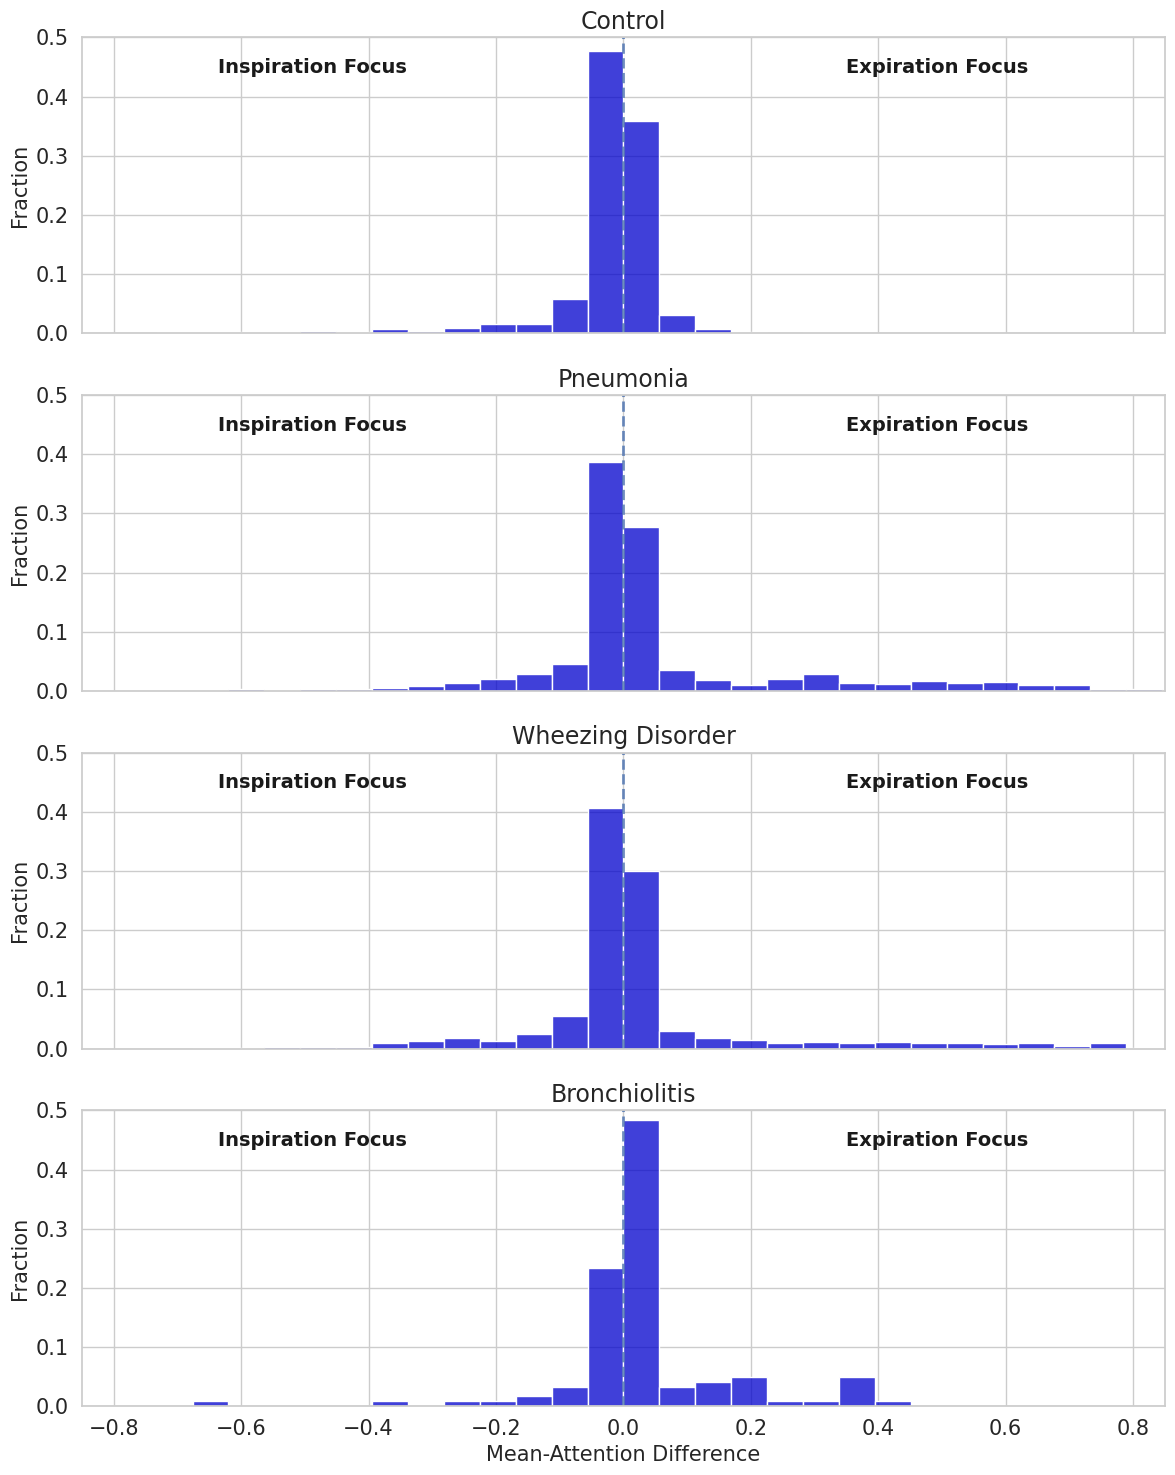

In [22]:
plot_attn_histograms(attn_df, target_str)

## Spectrogram Overlay

In [23]:
def get_time(idx, rate=4000, n_fft=256, hop_length=64):
    time = (idx*hop_length) / rate
    return time

In [24]:
def plot_expiration_attention(patient_id, location, diagnosis, position, val_fold, test_fold, idx, study, annotation="te"):
    if annotation == "ti":
        respiration_phase = "Inspiration" 
        annot_color = 'orange'
    else:
        respiration_phase = "Expiration"
        annot_color = 'r'
        
    position_df, attn_vals = get_test_data(val_fold, test_fold, target)
    
    selection = (position_df.location == "GVA").values
    selected_df = position_df[selection].reset_index(drop=True)
    attn_vals = attn_vals[selection]

    print(patient_id, diagnosis, position, val_fold, test_fold, idx)

    folder = "Cases" if diagnosis else "Controls"

    if study == "Pn":
        label_file = label_path.format(location, folder, patient_id, patient_id, position)
    else:
        label_file = as_label_path.format(location, folder, patient_id, patient_id, position)

    frame_attention = attn_vals[idx]
    n_frames = int(frame_attention[-1])
    frame_attention = frame_attention[:n_frames]
    max_attn = frame_attention.max()
    min_attn = frame_attention.min()
    #attn_scaled = minmax_scale(frame_attention)

    labels_df = pd.read_csv(label_file, sep='\t', header=None, names=["start", "end", "label"], dtype=str)
    labels_df["start"] = labels_df.start.apply(lambda s: float(s.replace(',', '.')))
    labels_df["end"] = labels_df.end.apply(lambda s: float(s.replace(',', '.')))
    labels_df["label"] = labels_df.label.fillna('NaN').apply(lambda s: s.split())
    labels_df = labels_df[labels_df.label.apply(lambda ls: annotation in ls)].reset_index(drop=True)

    timings = [get_time(i) for i in range(len(frame_attention))]

    x = [0]
    y = [min_attn]

    for _, r in labels_df.iterrows():
        x += [r.start, r.start, r.end, r.end]
        y += [min_attn, max_attn , max_attn, min_attn]

    fig = plt.figure(figsize=(17,6))
    ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])

    #fig1, = ax.step(x, y, where='post', label=respiration_phase)
    ax.fill_between(x, [min_attn for _ in range(len(x))], y, color=annot_color, alpha=.2, label=respiration_phase)
    ax.step(timings, frame_attention, where='mid', label='Attention', lw=2, color='k')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title(f"{respiration_phase} and Attention Curves")
        
    lgd = plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
    plt.xlim((0, 19.84))
    plt.show()
    
    return x, y, timings, frame_attention

In [25]:
import os

import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale

import src.preprocessing.features as feats
from src.utils.config import feat_config, split_config


def get_logmel(filepath, duration, feat_config=feat_config, split_config=split_config, spec_type='logmel'):
    """Get matrix of log-mel spectrogram for the specified record.

    Note:
        This can be used for records with no target.

    Args:
        feat_config (dict):
            The dictionary specifying the features' configurations.
        split_config (dict):
            The dictionary specifying the splits' configurations.
    """

    wav = feats.read_audio(filepath, duration=duration)

    if spec_type == 'logmel':
        spectrogram = feats.compute_logmel(wav, config=feat_config)
    else:
        spectrogram = feats.compute_log_stft(wav, config=feat_config)

    return spectrogram


def plot_logmel_with_attn(filepath, timings, frame_attention, duration=None, fig=None, ax=None, color='cyan'):
    """Plot log-mel spectrogram of specified record with the prediction overlaid.

    Note:
        This can be used for records with no target.

    Args:
        r (pd.Series):
            The record from a result dataframe. It should have the following indices
            {'file_name', 'split_id', 'study_code', 'resp_rate_pred'}.
        feat_config (dict):
            The dictionary specifying the features' configurations.
        split_config (dict):
            The dictionary specifying the splits' configurations.
        results_dict (dict):
            The nested dictionary of prediction results obtained from function TOSPECIFY.
        ax (matplotlib.axes):
            If true, plot the binarized signal. Else plot the raw signal.
    """
    spec = get_logmel(filepath, duration=duration)

    n_features, _ = spec.shape
    delta = 0.02
    plot_min = delta * n_features
    plot_max = (1-delta) * n_features

    if ax is None:
        fig, ax = plt.subplots(figsize=(17,6))
    
    img = librosa.display.specshow(
        spec, sr=feat_config['sr'], hop_length=feat_config['hop_length'], x_axis='time', cmap='magma',
        ax=ax)
    
    if fig is not None:
        colorbar = fig.colorbar(img, ax=ax, format="%+2.f dB")

    normalized_attn = minmax_scale(frame_attention, feature_range=(plot_min, plot_max))
    n_ticks = 6
    ax.step(timings, normalized_attn, label="Attention", lw=3, color=color)
    ax.set_yticks(np.linspace(plot_min, plot_max, n_ticks))
    ax.set_yticklabels(np.around(np.linspace(frame_attention.min(), frame_attention.max(), n_ticks), 3))
    ax.set_ylabel("Attention Amplitude")

    if ax is not None:
        return
    else:
        return fig, ax

In [26]:
from matplotlib.patches import Rectangle


def plot_spectrogram_attention(patient_id, location, diagnosis, position, val_fold, test_fold, idx, study, annotation="te", duration=13.856):
    if annotation == "ti":
        respiration_phase = "Inspiration" 
        annot_color = 'orange'
    else:
        respiration_phase = "Expiration"
        annot_color = 'r'
        
    position_df, attn_vals = get_test_data(val_fold, test_fold, target)
    
    selection = (position_df.location == "GVA").values
    selected_df = position_df[selection].reset_index(drop=True)
    attn_vals = attn_vals[selection]

    print(patient_id, diagnosis, position, val_fold, test_fold, idx)

    folder = "Cases" if diagnosis else "Controls"

    if study == "Pn":
        audio_file = audio_path.format(location, folder, patient_id, patient_id, position)
        label_file = label_path.format(location, folder, patient_id, patient_id, position)
    else:
        audio_file = as_audio_path.format(location, folder, patient_id, patient_id, position)
        label_file = as_label_path.format(location, folder, patient_id, patient_id, position)

    frame_attention = attn_vals[idx]
    n_frames = int(frame_attention[-1])
    frame_attention = frame_attention[:n_frames]
    max_attn = frame_attention.max()
    min_attn = frame_attention.min()
    #attn_scaled = minmax_scale(frame_attention)

    labels_df = pd.read_csv(label_file, sep='\t', header=None, names=["start", "end", "label"], dtype=str)
    labels_df["start"] = labels_df.start.apply(lambda s: float(s.replace(',', '.')))
    labels_df["end"] = labels_df.end.apply(lambda s: float(s.replace(',', '.')))
    labels_df["label"] = labels_df.label.fillna('NaN').apply(lambda s: s.split())
    labels_df = labels_df[labels_df.label.apply(lambda ls: annotation in ls)].reset_index(drop=True)

    timings = [get_time(i) for i in range(len(frame_attention))]

    x = [0]
    y = [min_attn]

    for _, r in labels_df.iterrows():
        x += [r.start, r.start, r.end, r.end]
        y += [min_attn, max_attn , max_attn, min_attn]

    fig, (ax1, ax0) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(17,6), gridspec_kw={'height_ratios': [1, 8]})
    #plot_logmel_with_attn(audio_file, timings, frame_attention)
    plot_logmel_with_attn(audio_file, timings, frame_attention, ax=ax0)
    #ax1.get_xaxis().set_visible(False)
    #ax1.get_yaxis().set_visible(False)
    print(ax0.get_xlim()[1])
    ax0.set_xlim((0, min(duration, ax0.get_xlim()[1])))
    lgd0 = ax0.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
    ax1.set_xlim(ax0.get_xlim())
    #ax1.grid(False)
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.axis('off')
    for i, r in labels_df.iterrows():
        start = r.start
        width = (r.end - r.start)
        ax1.add_patch(Rectangle((start, 0), width, 0.3, label=(respiration_phase if i == 0 else None), color=annot_color))
    lgd1 = ax1.legend(bbox_to_anchor=(1.03, 0.51), loc=2, borderaxespad=0.)
    
    fig_file = f"report/figures/attention_{patient_id}_{diagnosis}_{annotation}.png" 
    plt.tight_layout()
    plt.savefig(fig_file)
    plt.show()

In [27]:
inspiration_select = attn_df[(attn_df._mad < -0.6)].reset_index()
inspiration_select

,patient,location,position,val_fold,test_fold,idx,diagnosis,_mad
0,Pn_GVA_Ca50,GVA,P6,2,3,184,5,-0.631239
1,Pn_GVA_Co1,GVA,P7,2,4,6,0,-0.678890
2,Pn_GVA_Co6,GVA,P4,2,4,11,0,-0.632943
3,Pn_GVA_Co9,GVA,P3,4,2,10,0,-0.654423
4,Pn_GVA_Ca65,GVA,P2,4,2,63,1,-0.616357
5,Pn_GVA_Co6,GVA,P3,3,4,10,0,-0.610654
6,As_GVA_Ca29,GVA,P4,3,4,128,4,-0.675780


In [28]:
i = 6
patient_id = inspiration_select.at[i, "patient"]
location = inspiration_select.at[i, "location"]
diagnosis = inspiration_select.at[i, "diagnosis"]
position = inspiration_select.at[i, "position"]
val_fold = inspiration_select.at[i, "val_fold"]
test_fold = inspiration_select.at[i, "test_fold"]
idx = inspiration_select.at[i, "idx"]
mad = inspiration_select.at[i, "_mad"]
print(mad)
study = patient_id.split('_')[0]

-0.6757800446451814


4718 4718
As_GVA_Ca29 4 P4 3 4 128


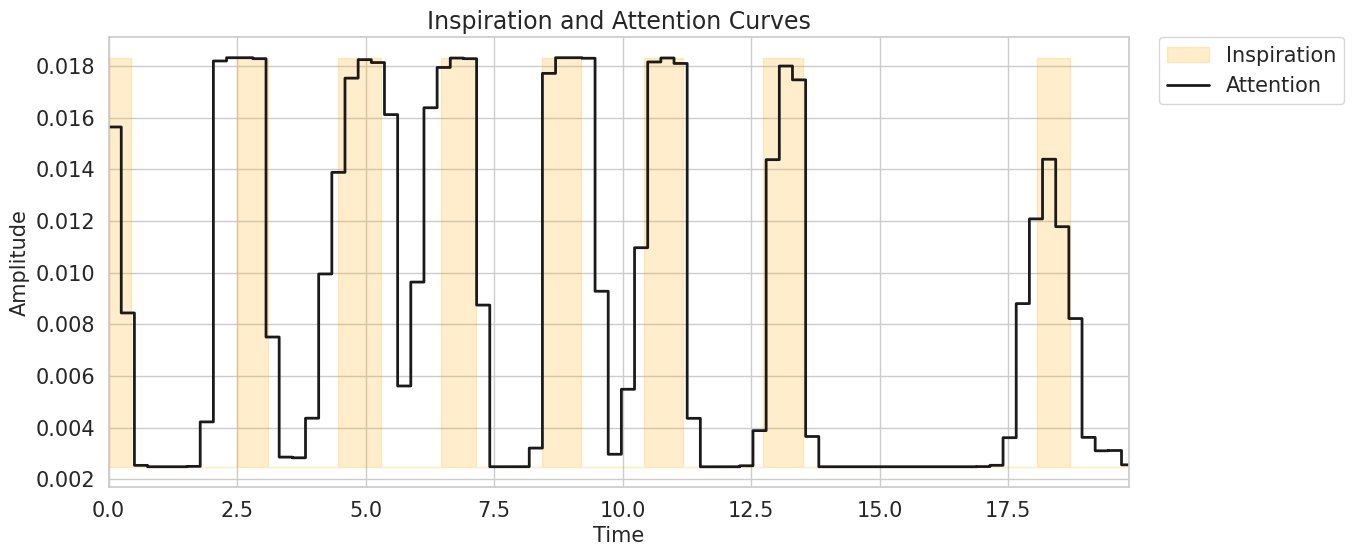

In [29]:
x_1, y_1, timings_1, frame_attention_1 = plot_expiration_attention(patient_id, location, diagnosis, position, val_fold, test_fold, idx, study, annotation="ti")

4718 4718
As_GVA_Ca29 4 P4 3 4 128
30.008


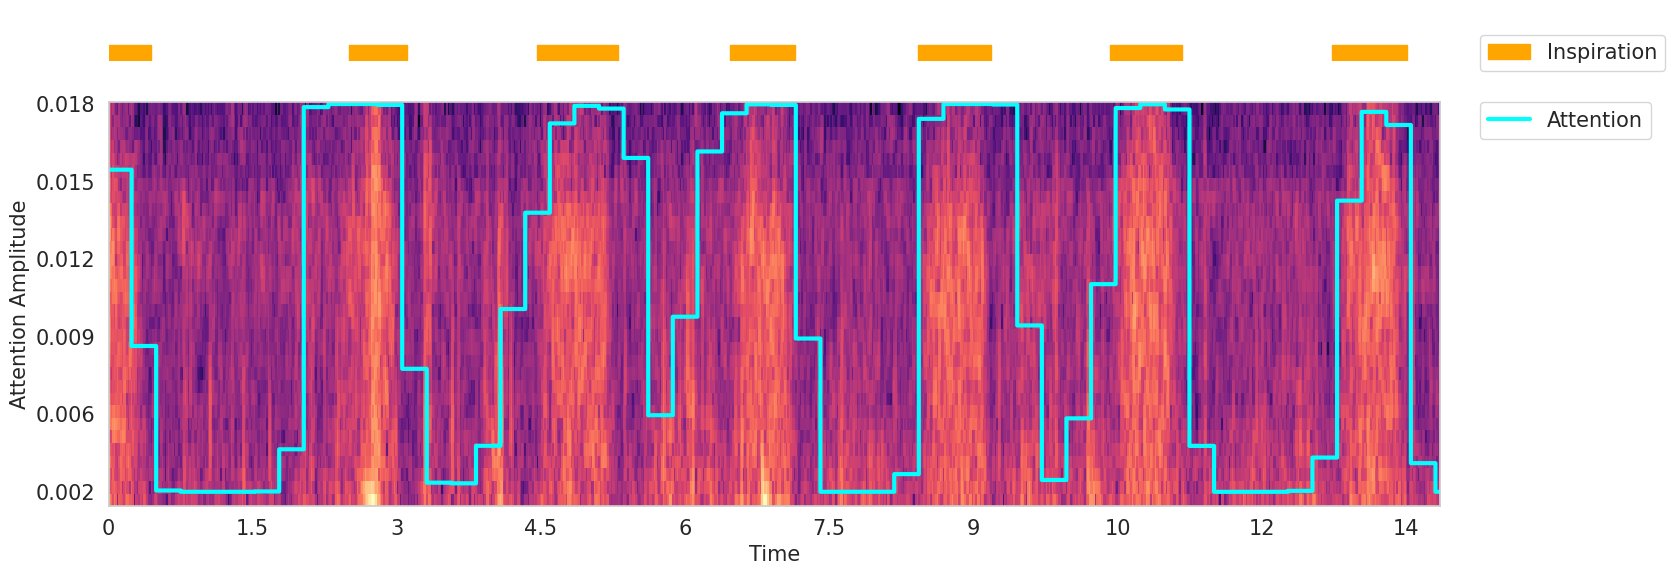

In [30]:
plot_spectrogram_attention(patient_id, location, diagnosis, position, val_fold, test_fold, idx, study, annotation="ti")

In [31]:
mid_select = attn_df[(0.3 < attn_df._mad) & (attn_df._mad < 0.5)].reset_index()
mid_select.head()

,patient,location,position,val_fold,test_fold,idx,diagnosis,_mad
0,Pn_GVA_Ca24,GVA,P1,0,3,32,1,0.377813
1,Pn_GVA_Ca42,GVA,P1,0,3,40,1,0.431357
2,Pn_GVA_Ca42,GVA,P3,0,3,42,1,0.335017
3,Pn_GVA_Ca42,GVA,P5,0,3,44,1,0.420817
4,Pn_GVA_Ca55,GVA,P4,0,3,49,1,0.391654


In [32]:
i = 0  # 2 7 8 14 22  29
patient_id = mid_select.at[i, "patient"]
location = mid_select.at[i, "location"]
diagnosis = mid_select.at[i, "diagnosis"]
position = mid_select.at[i, "position"]
val_fold = mid_select.at[i, "val_fold"]
test_fold = mid_select.at[i, "test_fold"]
idx = mid_select.at[i, "idx"]
mad = mid_select.at[i, "_mad"]
print(mad)
study = patient_id.split('_')[0]

0.37781320864853657


4718 4718
Pn_GVA_Ca24 1 P1 0 3 32


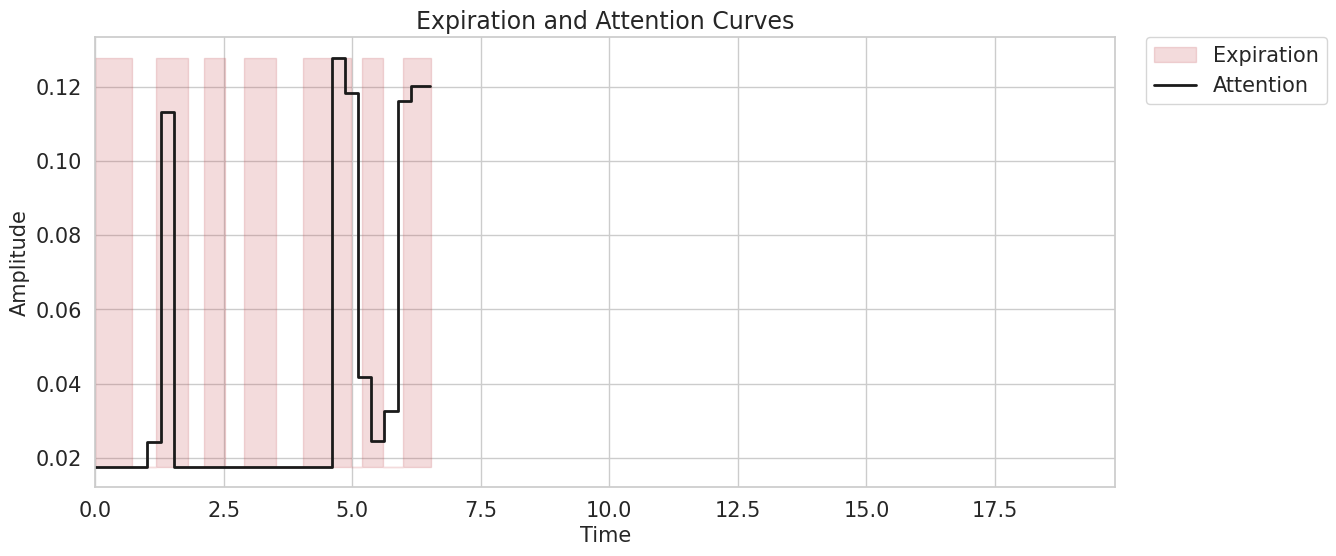

In [33]:
x_2, y_2, timings_2, frame_attention_2 = plot_expiration_attention(patient_id, location, diagnosis, position, val_fold, test_fold, idx, study, annotation="te")

In [34]:
expiration_select = attn_df[(attn_df._mad > 0.75)].reset_index()
expiration_select

,patient,location,position,val_fold,test_fold,idx,diagnosis,_mad
0,Pn_GVA_Ca44,GVA,P1,3,0,103,3,0.800119
1,Pn_GVA_Ca44,GVA,P2,3,0,104,3,0.764252
2,Pn_GVA_Ca44,GVA,P7,3,0,109,3,0.766221
3,Pn_GVA_Ca45,GVA,P6,4,0,61,1,0.807340
4,Pn_GVA_Ca44,GVA,P1,4,0,103,3,0.806358
5,Pn_GVA_Ca44,GVA,P2,4,0,104,3,0.770618
6,Pn_GVA_Ca44,GVA,P7,4,0,109,3,0.767799
7,Pn_GVA_Ca47,GVA,P5,2,1,109,3,0.760102
8,Pn_GVA_Ca47,GVA,P5,3,1,109,3,0.762976
9,Pn_GVA_Ca47,GVA,P7,3,1,111,3,0.757673


In [35]:
i = 7
patient_id = expiration_select.at[i, "patient"]
location = expiration_select.at[i, "location"]
diagnosis = expiration_select.at[i, "diagnosis"]
position = expiration_select.at[i, "position"]
val_fold = expiration_select.at[i, "val_fold"]
test_fold = expiration_select.at[i, "test_fold"]
idx = expiration_select.at[i, "idx"]
mad = expiration_select.at[i, "_mad"]
print(mad)
study = patient_id.split('_')[0]

0.760101815811209


4718 4718
Pn_GVA_Ca47 3 P5 2 1 109


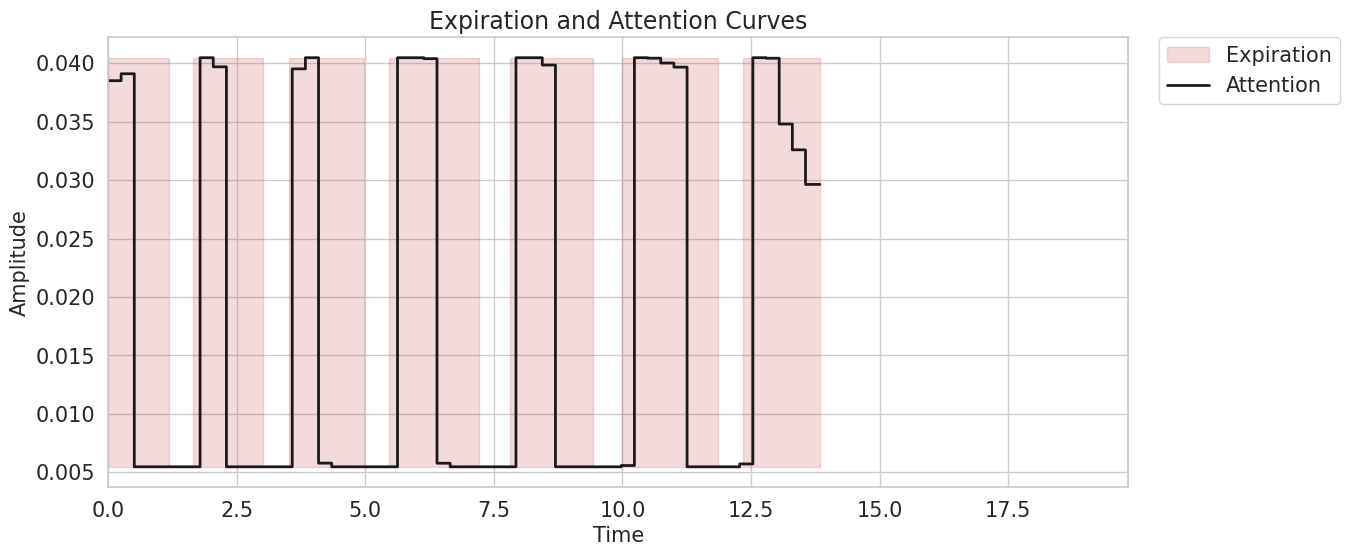

In [36]:
x_3, y_3, timings_3, frame_attention_3 = plot_expiration_attention(patient_id, location, diagnosis, position, val_fold, test_fold, idx, study, annotation="te")

4718 4718
Pn_GVA_Ca47 3 P5 2 1 109
13.847999999999999


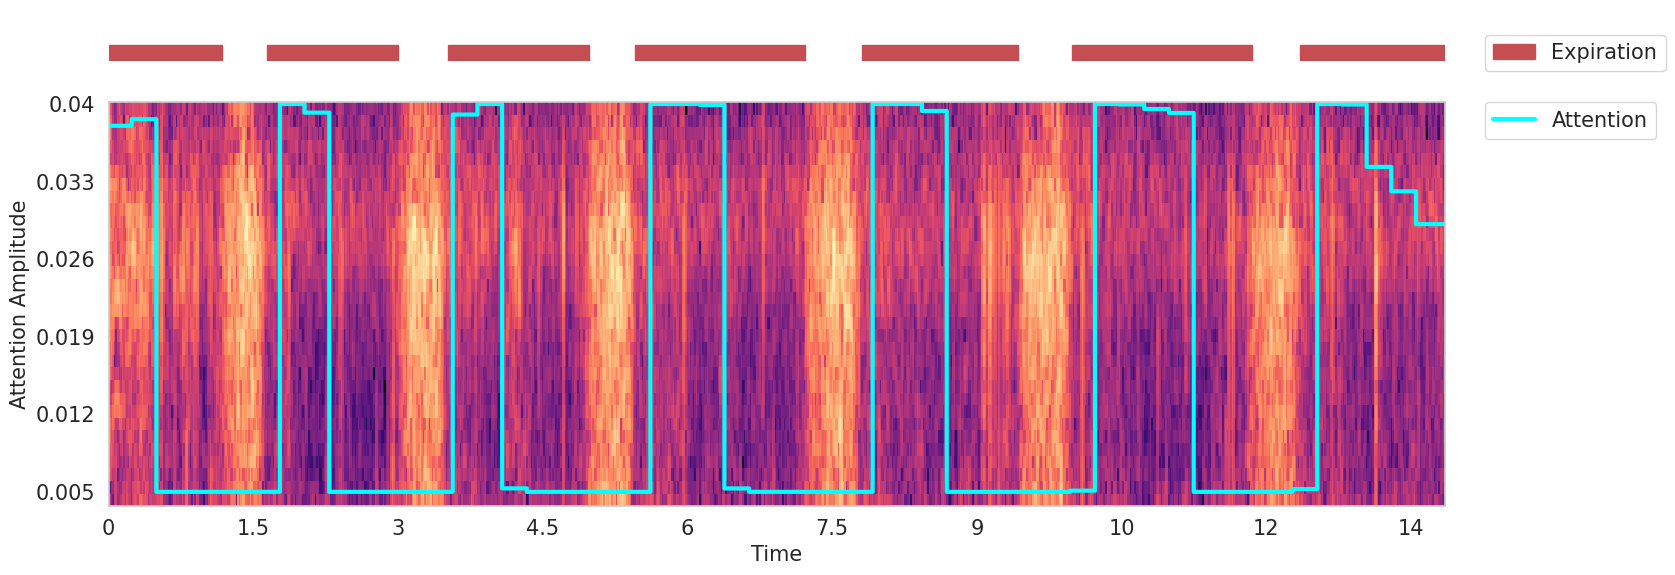

In [37]:
plot_spectrogram_attention(patient_id, location, diagnosis, position, val_fold, test_fold, idx, study, annotation="te")

In [38]:
bronchio_select = attn_df[(attn_df.diagnosis == 0)].sort_values(by="_mad", ascending=False).reset_index()
bronchio_select

,patient,location,position,val_fold,test_fold,idx,diagnosis,_mad
0,Pn_GVA_Co1,GVA,P4,2,4,3,0,0.324778
1,Pn_GVA_Co11,GVA,P5,0,4,19,0,0.208385
2,Pn_GVA_Co11,GVA,P6,0,4,20,0,0.185417
3,Pn_GVA_Co5,GVA,P1,0,3,0,0,0.140468
4,Pn_GVA_Co21,GVA,P8,0,4,38,0,0.129790
...,...,...,...,...,...,...,...,...
727,Pn_GVA_Co9,GVA,P2,4,2,9,0,-0.549483
728,Pn_GVA_Co6,GVA,P3,3,4,10,0,-0.610654
729,Pn_GVA_Co6,GVA,P4,2,4,11,0,-0.632943
730,Pn_GVA_Co9,GVA,P3,4,2,10,0,-0.654423


In [39]:
i = 730
patient_id = bronchio_select.at[i, "patient"]
location = bronchio_select.at[i, "location"]
diagnosis = bronchio_select.at[i, "diagnosis"]
position = bronchio_select.at[i, "position"]
val_fold = bronchio_select.at[i, "val_fold"]
test_fold = bronchio_select.at[i, "test_fold"]
idx = bronchio_select.at[i, "idx"]
mad = bronchio_select.at[i, "_mad"]
print(mad)
study = patient_id.split('_')[0]

-0.6544231266706546


4718 4718
Pn_GVA_Co9 0 P3 4 2 10


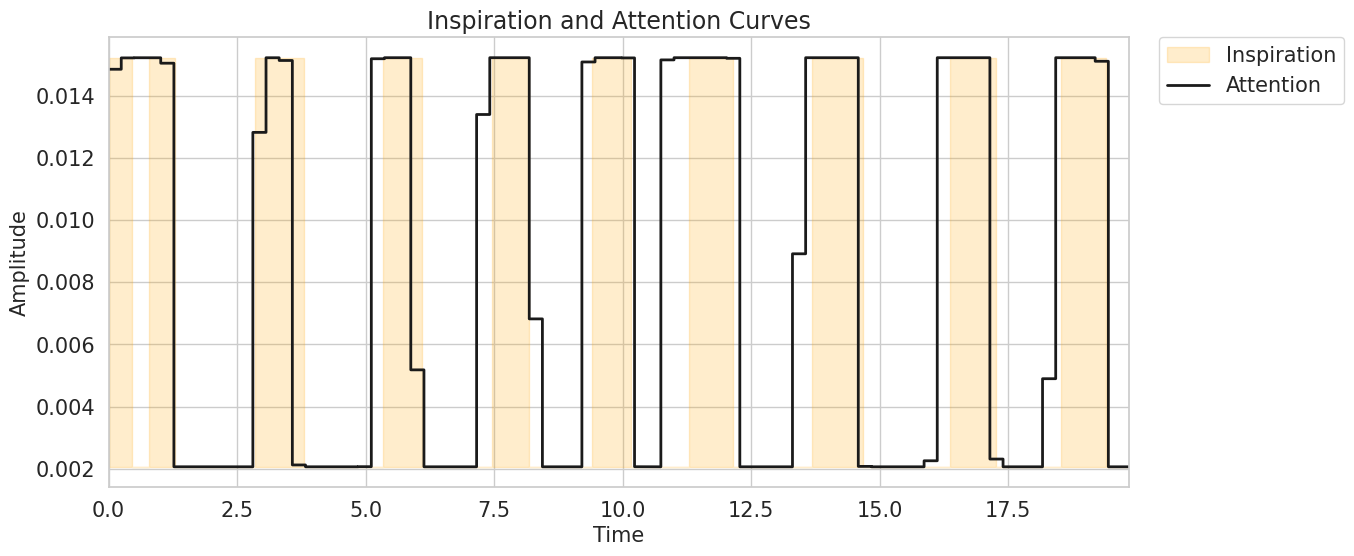

In [40]:
x_3, y_3, timings_3, frame_attention_3 = plot_expiration_attention(patient_id, location, diagnosis, position, val_fold, test_fold, idx, study, annotation="ti")

4718 4718
Pn_GVA_Co9 0 P3 4 2 10
31.0


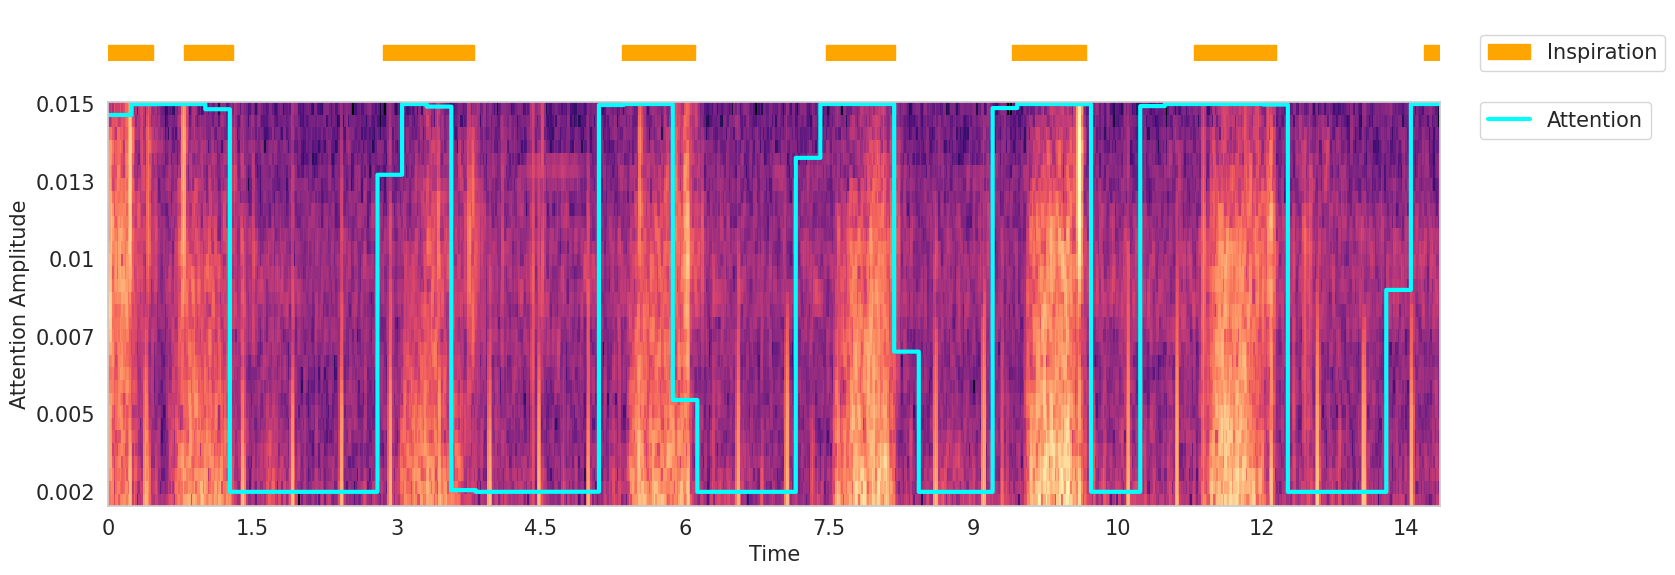

In [41]:
plot_spectrogram_attention(patient_id, location, diagnosis, position, val_fold, test_fold, idx, study, annotation="ti")